# Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

Create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

# Import the python libraries

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Helper Functions

## Datasets

In [3]:
def prepare_train_dataset(file, columns):
    df_train = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
    df_train = df_train[(df_train['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df_train['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
    df_train['owed_amount'] = df_train['judgment_amount'] - df_train['discount_amount']
    X = df_train[columns]
    y = df_train['compliance']

    return X,y

In [37]:
def prepare_test_dataset(file, columns):
    df_test = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
    df_test = df_test[(df_test['city'].str.lower() == 'detroit')].set_index('ticket_id')
    df_test['owed_amount'] = df_test['judgment_amount'] - df_test['discount_amount']
    X = df_test[columns]

    return X

In [4]:
def transform(le, data_list):
    """
    This will transform the data_list to id list where the new values get assigned to Unknown class
    :param data_list:
    :return:
    """
    new_data_list = list(data_list)
    for unique_item in np.unique(data_list):
        if unique_item not in le.classes_:
            new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

    return le.transform(new_data_list)

## Plots

In [5]:
def define_percentage_compliance(df, field):
    compliance={}
    compliance_values = [0,1]
    for value in compliance_values:
        compliance[value] = []
    total_people = df[field].count()

    compliance[1] = df[df['compliance'] == 1][field].value_counts()
    compliance[0] = df[df['compliance'] == 0][field].value_counts()
    compliance['total'] = total_people
    
    return compliance

In [6]:
def define_percentage_compliance_folds(df, field, compliance_field='compliance', compliance_values=[0,1], folds=[50, 100, 150, 200, 250, 300, 350, 'rest']):
    compliance={}
    for value in compliance_values:
        compliance[value] = []
        
    total_people = df[field].count()
    
    for i in range(len(folds)):
        if folds[i] == 'rest':
            for value in compliance_values:
                compliance[value].append(df[(df[field] > folds[i-1]) & (df[compliance_field] == value)][field].count())
        elif i == 0:
            for value in compliance_values:
                compliance[value].append(df[(df[field] <= folds[i]) & (df[compliance_field] == value)][field].count())
        else:
            for value in compliance_values:
                compliance[value].append(df[(df[field] > folds[i-1]) & (df[field] <= folds[i]) & (df[compliance_field] == value)][field].count())

    for key, values in compliance.items():
        compliance[key] = [element/total_people for element in values]
    
    return compliance

In [7]:
def plot_percent_compliance_bar_folds_chart(y, w=10, folds=[50, 100, 150, 200, 250, 300, 350, 400], folds_ticks=['0~50', '50~100', '100~150', '150~200', '200~250', '250~300', '300~350', '>350'], legend=['Compliant', 'Not Compliant']):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.bar([element - w/2 for element in folds], y[1], width=w) 
    ax.bar([element + w/2 for element in folds], y[0], width=w) 
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(folds, folds_ticks)
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [8]:
def plot_percent_compliance_bar_chart(field, xlim=(), ylim=(), legend=['Compliant', 'Not Compliant']):
    compliance = define_percentage_compliance(df, field)
    plt.figure(figsize=(12,6))
    ax = plt.subplot()
    w = 1
    ax.bar([element - w/2 for element in list(compliance[1].index)], compliance[1].apply(lambda x: x/compliance['total']), width=w) 
    ax.bar([element + w/2 for element in list(compliance[0].index)], compliance[0].apply(lambda x: x/compliance['total']), width=w)

    
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [9]:
def plot_percent_compliance_scatter_chart(field, xlim=(), ylim=(), legend=['Compliant', 'Not Compliant']):
    compliance = define_percentage_compliance(df, field)
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.scatter(compliance[1].index, compliance[1].apply(lambda x: x/compliance['total']), marker='o') 
    ax.scatter(compliance[0].index, compliance[0].apply(lambda x: x/compliance['total']), marker='o')
    
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [10]:
def plot_compliance_scatter_features_chart(df, x, y, colors = ['#FF7F0E', '#1F77B4'], xticks=[], yticks=[], xlim=(), ylim=(), legend=['Not Compliant', 'Compliant']):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.scatter(df[x], df[y], c=df['compliance'], cmap=ListedColormap(colors), marker='o') 
    
    if len(xticks) > 0:
        x_interval=[]
        for i in range(len(xticks)):
            x_interval.append(i)
        plt.xticks(x_interval, xticks)
    
    if len(yticks) > 0:
        y_interval=[]
        for i in range(len(yticks)):
            y_interval.append(i)
        plt.yticks(y_interval, yticks)
        
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    legend_handles = []
    for i in range(0, len(legend)):
        patch = mpatches.Patch(color=colors[i], label=legend[i])
        legend_handles.append(patch)
    ax.legend(loc=0, handles=legend_handles, framealpha=0.0)
    
    plt.show()

# 1. Data information

First I removed all entries that are not from Detroit and the person was not fined (considered not responsible or compliant by no fine)

In [97]:
df = pd.read_csv('csv/train.csv', encoding='ISO-8859-1', low_memory=False)
df = df[(df['city'].str.lower() == 'detroit') & (~df['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')

print(f'Number of Examples = {df.shape[0]}')
print(f'X Shape = {df.shape}')
print(f'y Shape = {df["compliance"].shape[0]}\n')

Number of Examples = 95865
X Shape = (95865, 33)
y Shape = 95865



## 1.1 Missing values

In [98]:
print(f'Only features contained missing value in Dataset')
temp = df.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Dataset
violator_name                    14
violation_zip_code            95865
mailing_address_str_number      697
non_us_str_code               95865
hearing_date                    115
payment_date                  73305
collection_status             76381
grafitti_status               95865
dtype: int64 



Drop the columns that most of rows are missing values, except for the payment_date column that may contain some useful information about the problem

In [99]:
null_features = df.isnull().sum()
all_null = df.columns[list(null_features == 95865)]
df.drop(all_null, axis=1, inplace=True)
df.drop('collection_status', axis=1, inplace=True)

Drop the rows that has missing values for the remaining features, since they represent a really small portion of the dataset

In [101]:
null_features = df.isnull().sum()
null_1000 = df.columns[list((null_features < 1000) & (null_features != 0))]
df.drop(df[df[null_1000].isnull().any(axis=1)].index, inplace=True)

In [102]:
print(f'Number of Examples = {df.shape[0]}')
print(f'X Shape = {df.shape}')
print(f'y Shape = {df["compliance"].shape[0]}\n')

Number of Examples = 95045
X Shape = (95045, 29)
y Shape = 95045



## 1.2 Numeric Features

In [108]:
df.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,9.504500e+04,9.504500e+04,95045.000000,95045.0,95045.0,95045.000000,95045.000000,95045.0,95045.000000,95045.000000,95045.000000,95045.000000
mean,1.028994e+04,7.877645e+03,322.202851,20.0,10.0,30.410558,0.140544,0.0,382.613409,57.325983,325.146967,0.069262
std,4.667126e+04,2.306819e+04,593.180670,0.0,0.0,59.547680,2.677393,0.0,652.094356,164.378549,657.148433,0.253900
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000
25%,4.302000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000
50%,9.440000e+03,2.663000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,1.539000e+04,1.354300e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


In [109]:
df[df['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,payment_amount,balance_due
ticket_id,,,,
20851,30.0,330.0,260.0,40.0
22450,25.0,280.0,280.0,-25.0
22634,10.0,130.0,120.0,0.0
22757,25.0,280.0,255.0,0.0
24321,25.0,280.0,280.0,-25.0


Analysing the tables above and the variable descriptions given, I decided to use the total owed amount value to train the model.<br>
Since there is no column with this value, I created the owed_amount column with the following formula:
<p style='text-align:center;'><strong>owed_amount = judgment_amount - discount_amount</strong></p>

In [110]:
df['owed_amount'] = df['judgment_amount'] - df['discount_amount']
df[df['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,payment_amount,balance_due
ticket_id,,,,
20851,30.0,330.0,260.0,40.0
22450,25.0,280.0,280.0,-25.0
22634,10.0,130.0,120.0,0.0
22757,25.0,280.0,255.0,0.0
24321,25.0,280.0,280.0,-25.0


In [116]:
df_corr = df.corr()['compliance'].sort_values(ascending=False).drop(['compliance'])

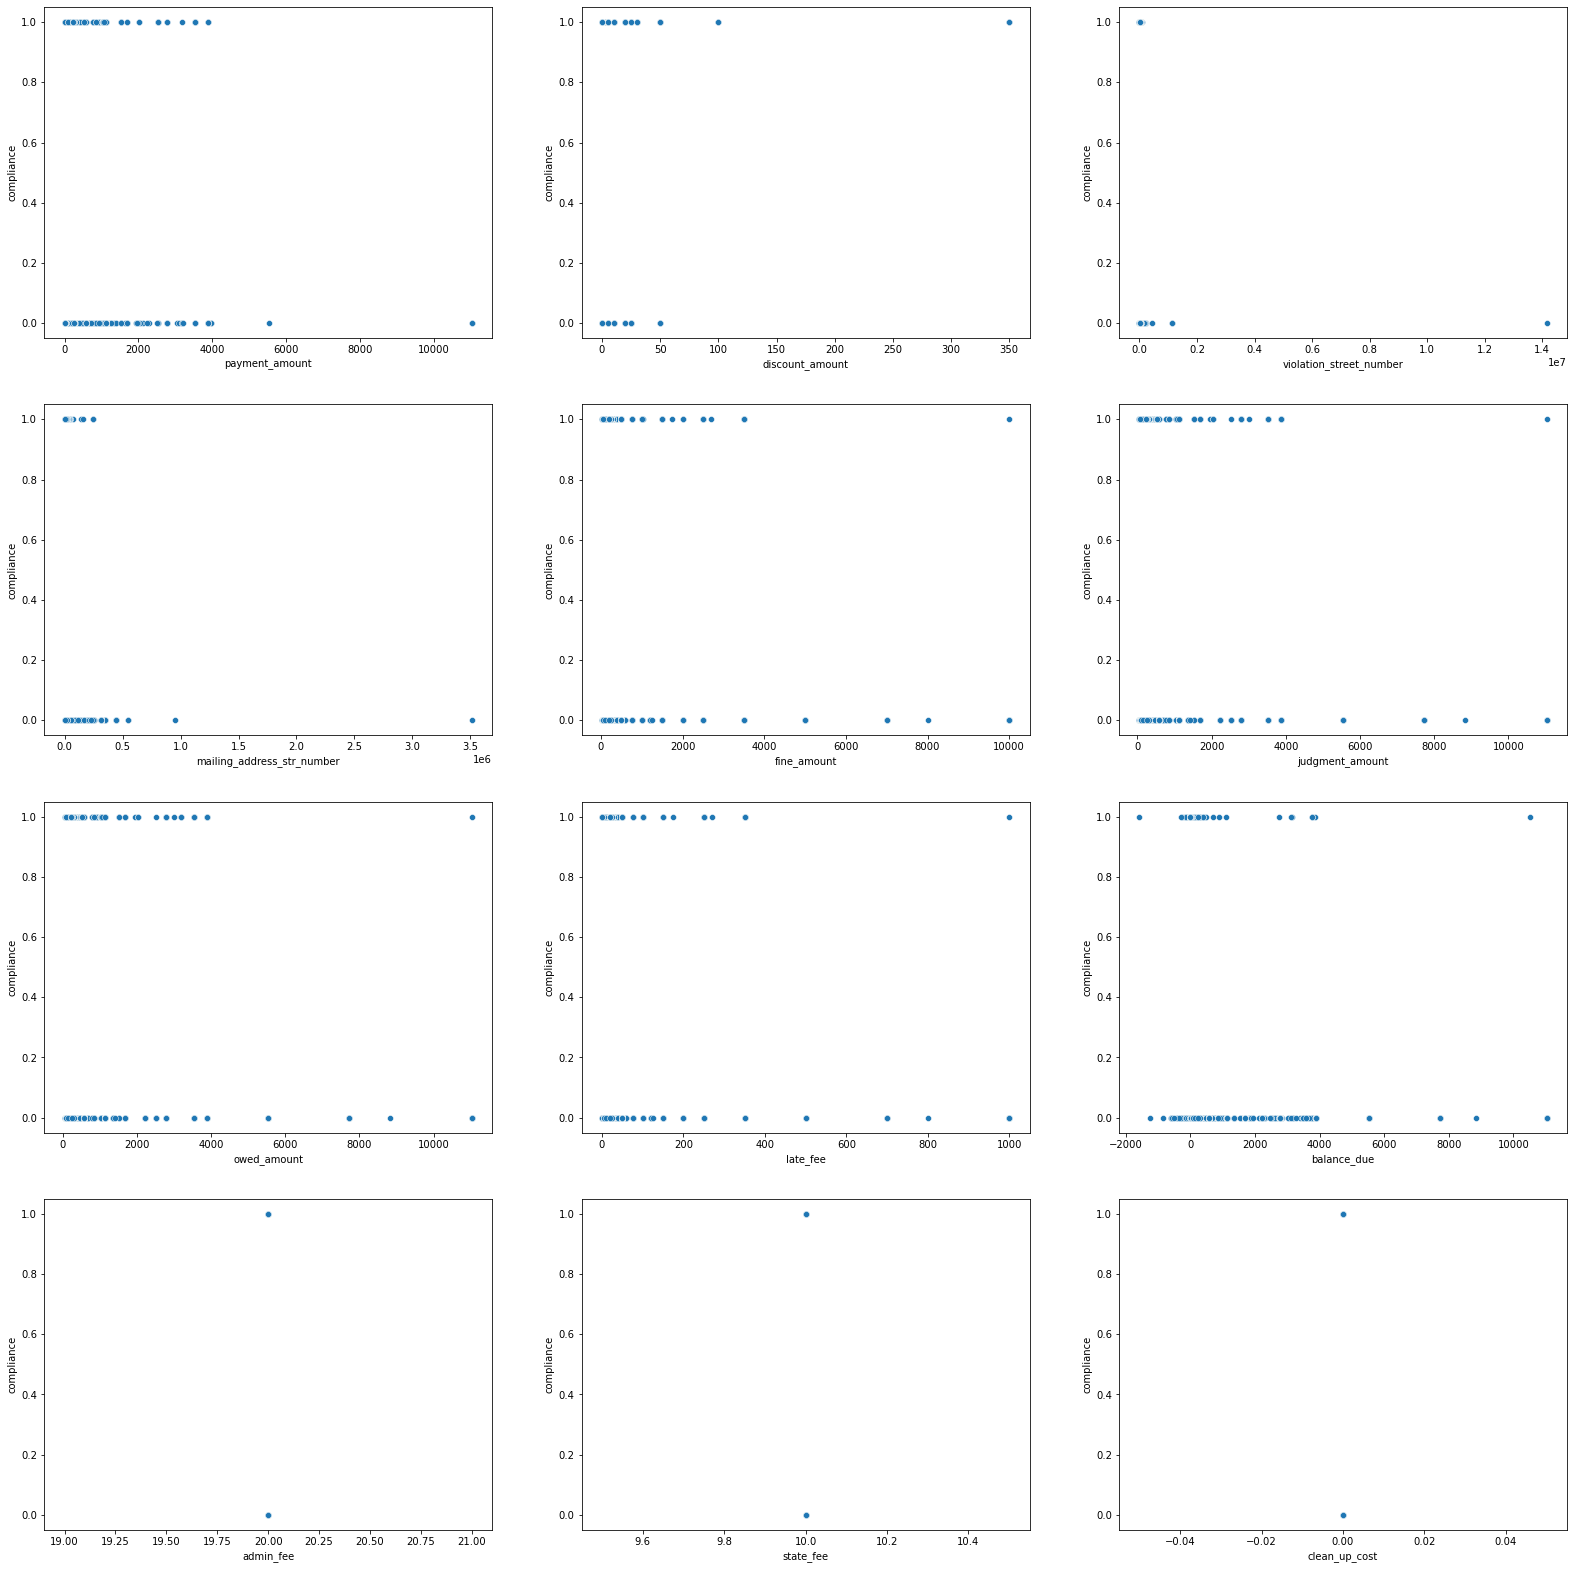

In [121]:
fig, axs = plt.subplots(4, 3, figsize=(18, 18))
plt.subplots_adjust(right=1.3, top=1.3)
axs = axs.flatten()
for i, col in enumerate(list(df_corr.index[:])):
    sns.scatterplot(y='compliance', x=col, ax=axs[i], data=df)
    axs[i].set_ylabel('compliance')
    axs[i].set_xlabel(col)
plt.show()

In [127]:
df_cate = df.select_dtypes(include=['object', 'category'])
df_cate.head()

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,payment_date,payment_status,compliance_detail
ticket_id,,,,,,,,,,,,,,,,,
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",CENTRAL,Martin Luther King,Detroit,MI,48208,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,2005-06-02 00:00:00,PAID IN FULL,compliant by late payment within 1 month
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",MT ELLIOTT,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,NaN,NO PAYMENT APPLIED,non-compliant by no payment
18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",MT ELLIOTT,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,NaN,NO PAYMENT APPLIED,non-compliant by no payment
28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",SEVEN MILE,E. Seven Mile,Detroit,MI,48205,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,NaN,NO PAYMENT APPLIED,non-compliant by no payment
18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",VAN DYKE,Van Dyke,Detroit,MI,48213,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,NaN,NO PAYMENT APPLIED,non-compliant by no payment


We can analyse the data in order to be aware of the amount of compliant and non-compliant people in Detroit and understand how this problem is actually affecting the city

In [111]:
total_compliant_people = df[df['compliance'] == 1]['compliance'].value_counts().sum()
total_non_compliant_people = df[df['compliance'] == 0]['compliance'].value_counts().sum()
total_people = total_compliant_people + total_non_compliant_people
print('Percentage of compliant people: {:.2f}%'.format(total_compliant_people/total_people*100))
print('Percentage of non-compliant people: {:.2f}%'.format(total_non_compliant_people/total_people*100))

Percentage of compliant people: 6.93%
Percentage of non-compliant people: 93.07%


Also, we can take a look at the amounts being charged

In [16]:
df.iloc[:,13:].head()

,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,owed_amount
ticket_id,,,,,,,,,,,,,,,,,,,,,
27586,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,...,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,855.0
18735,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,...,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,140.0
18733,2004-06-16 12:25:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,...,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,140.0
28204,2004-07-12 13:30:00,2005-05-31 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,...,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,855.0
18743,2004-07-28 12:15:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,...,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0,855.0


In [17]:
df[['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount', 
   'payment_amount', 'hearing_date', 'payment_date', 'payment_status', 'balance_due', 'compliance_detail', 'compliance']].head()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,hearing_date,payment_date,payment_status,balance_due,compliance_detail,compliance
ticket_id,,,,,,,,,,,,,,
27586,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,2005-05-06 13:30:00,2005-06-02 00:00:00,PAID IN FULL,75.0,compliant by late payment within 1 month,1.0
18735,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,2005-02-22 15:00:00,NaN,NO PAYMENT APPLIED,140.0,non-compliant by no payment,0.0
18733,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,2005-02-22 15:00:00,NaN,NO PAYMENT APPLIED,140.0,non-compliant by no payment,0.0
28204,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,2005-05-31 13:30:00,NaN,NO PAYMENT APPLIED,855.0,non-compliant by no payment,0.0
18743,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,2005-02-22 15:00:00,NaN,NO PAYMENT APPLIED,855.0,non-compliant by no payment,0.0


In [18]:
print('Total paid amount: ${0:,.2f}'.format(df['payment_amount'].sum()))

Total paid amount: $5,517,134.60


In [19]:
df['payment_year'] = df['payment_date'].str.extract(r'(\d{4})')
df.groupby('payment_year').agg({'payment_amount':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,payment_amount
payment_year,
2005,"$ 601,544.50"
2006,"$ 830,015.50"
2007,"$ 910,494.40"
2008,"$ 868,401.30"
2009,"$ 653,808.80"
2010,"$ 687,175.50"
2011,"$ 377,969.50"
2012,"$ 132,856.10"
2013,"$ 111,162.20"


In [20]:
print('Total pending payment amount: ${0:,.2f}'.format(df['balance_due'].sum()))

Total pending payment amount: $31,394,287.00


In [21]:
df['ticket_issued_year'] = df['ticket_issued_date'].str.extract(r'(\d{4})')
df.groupby('ticket_issued_year').agg({'owed_amount':np.sum, 'balance_due':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,owed_amount,balance_due
ticket_issued_year,,
1988,$ 85.00,$ 0.00
2004,"$ 7,400.00","$ 6,360.00"
2005,"$ 5,259,471.50","$ 3,990,913.60"
2006,"$ 7,734,662.00","$ 6,501,416.30"
2007,"$ 7,519,275.00","$ 6,661,972.90"
2008,"$ 7,068,165.00","$ 6,113,297.40"
2009,"$ 4,748,842.50","$ 4,123,292.20"
2010,"$ 2,594,500.00","$ 2,271,804.00"
2011,"$ 1,979,012.50","$ 1,725,230.60"


In [22]:
df['compliance_detail'].value_counts()

non-compliant by no payment                        78359
non-compliant by late payment more than 1 month    10800
compliant by late payment within 1 month            3610
compliant by on-time payment                        2388
compliant by early payment                           585
compliant by payment with no scheduled hearing        77
compliant by payment on unknown date                  46
Name: compliance_detail, dtype: int64

In [23]:
df['compliance_detail'].value_counts(normalize=True).apply(lambda x: '{:.2f}%'.format(x*100))

non-compliant by no payment                        81.74%
non-compliant by late payment more than 1 month    11.27%
compliant by late payment within 1 month            3.77%
compliant by on-time payment                        2.49%
compliant by early payment                          0.61%
compliant by payment with no scheduled hearing      0.08%
compliant by payment on unknown date                0.05%
Name: compliance_detail, dtype: object

In [24]:
df.groupby('compliance_detail').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,owed_amount,payment_amount,balance_due
compliance_detail,,,
compliant by early payment,"$ 130,447.00","$ 122,104.00","$ 8,351.00"
compliant by late payment within 1 month,"$ 991,147.00","$ 906,694.80","$ 84,452.20"
compliant by on-time payment,"$ 576,665.00","$ 576,625.00",$ 40.00
compliant by payment on unknown date,"$ 15,577.50","$ 15,582.50",$ -5.00
compliant by payment with no scheduled hearing,"$ 26,075.00","$ 30,645.00","$ -4,570.00"
non-compliant by late payment more than 1 month,"$ 3,260,327.00","$ 2,886,276.70","$ 374,050.30"
non-compliant by no payment,"$ 31,911,175.00","$ 979,206.60","$ 30,931,968.50"


In [25]:
df.groupby('compliance').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,owed_amount,payment_amount,balance_due
compliance,,,
0.0,"$ 35,171,502.00","$ 3,865,483.30","$ 31,306,018.80"
1.0,"$ 1,739,911.50","$ 1,651,651.30","$ 88,268.20"


In [26]:
df.describe()

,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,owed_amount
count,9.586500e+04,0.0,9.516800e+04,95865.000000,95865.0,95865.0,95865.000000,95865.000000,95865.0,95865.000000,95865.000000,95865.000000,95865.000000,95865.000000
mean,1.029785e+04,NaN,7.873750e+03,324.560789,20.0,10.0,30.632728,0.158170,0.0,385.193517,57.551083,327.484348,0.069953,385.035347
std,4.647504e+04,NaN,2.305454e+04,599.643509,0.0,0.0,60.198046,2.905758,0.0,659.207965,166.379413,664.317336,0.255068,659.171134
min,0.000000e+00,NaN,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-3280.000000,0.000000,52.000000
25%,4.309000e+03,NaN,8.310000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000,250.000000
50%,9.501000e+03,NaN,2.661000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
75%,1.539700e+04,NaN,1.354100e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
max,1.415411e+07,NaN,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,11030.000000


Since the mean value of the owed_amount column is 385.0, 75% of the values are lower than 305 and the standard deviation is 659.2, we can infer that there are a lot of outliers in this column.
I plotted some charts to have an overview of the distribution of the column values.

# Feature Informations

## owed_amount

Bar plot with interval percentages

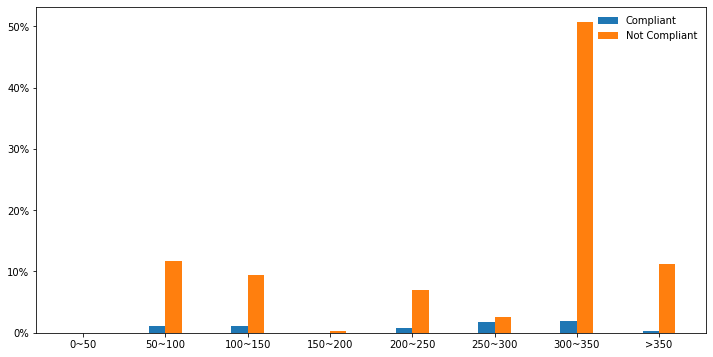

In [16]:
compliance_sizes = define_percentage_compliance_folds(df, 'owed_amount')
plot_percent_compliance_bar_folds_chart(compliance_sizes)

Scatter plot with percentage value of each exact amount

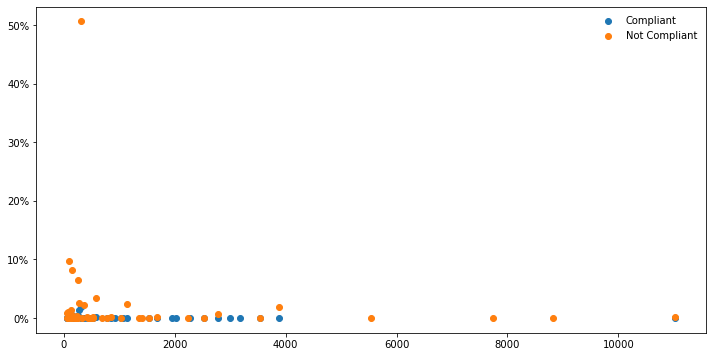

In [17]:
plot_percent_compliance_scatter_chart('owed_amount')

Zoomed the scatter plot to owed amounts between 0 and 400 dolars.

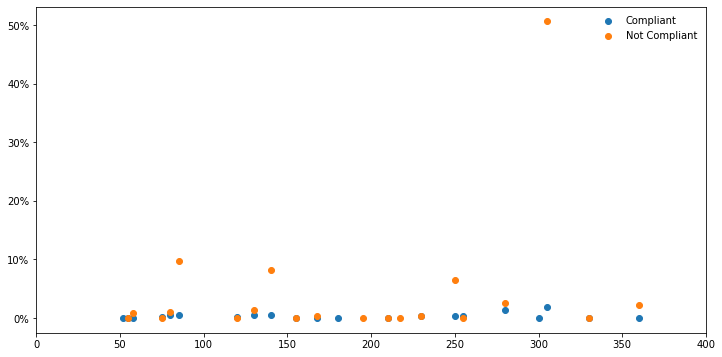

In [18]:
plot_percent_compliance_scatter_chart('owed_amount', xlim=(0,400))

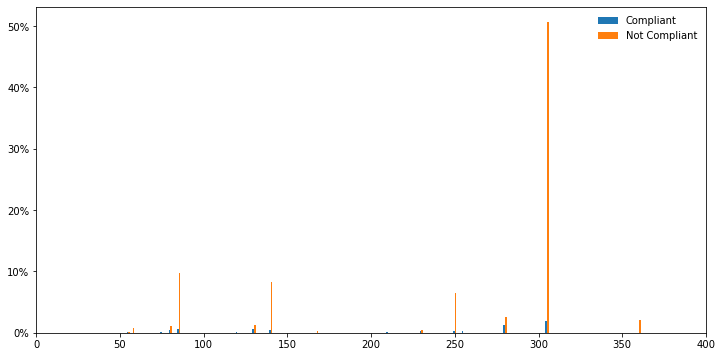

In [19]:
plot_percent_compliance_bar_chart('owed_amount', xlim=(0,400))

## disposition

Plot the scatter chart to visualize the distribution of compliant and not compliant entries by disposition

In [20]:
df['disposition'].unique()

array(['Responsible by Determination', 'Responsible by Default',
       'Responsible by Admission'], dtype=object)

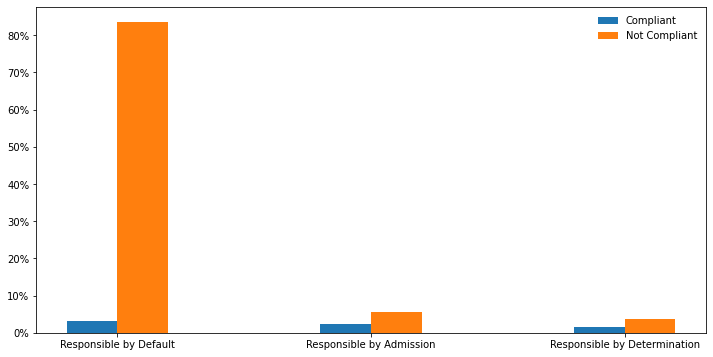

In [21]:
total_people = df['disposition'].count()
compliance_sizes={}
compliance_sizes[1] = df[df['compliance'] == 1]['disposition'].value_counts().apply(lambda x: x/total_people)
compliance_sizes[0] = df[df['compliance'] == 0]['disposition'].value_counts().apply(lambda x: x/total_people)
plot_percent_compliance_bar_folds_chart(compliance_sizes, folds=[50, 100, 150], folds_ticks=compliance_sizes[0].index)

Distribution of compliant and not compliant entries using both features

In [22]:
df['disposition'].unique()

array(['Responsible by Determination', 'Responsible by Default',
       'Responsible by Admission'], dtype=object)

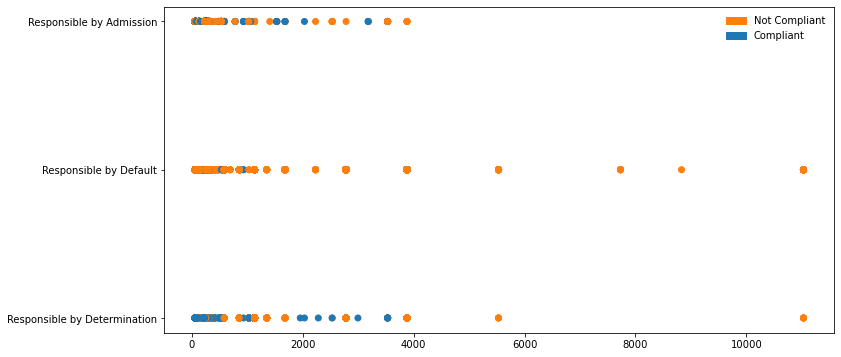

In [23]:
df['disposition_category'] = 2
df.loc[df.disposition == 'Responsible by Determination', 'disposition_category'] = 0
df.loc[df.disposition == 'Responsible by Default', 'disposition_category'] = 1

plot_compliance_scatter_features_chart(df, 'owed_amount', 'disposition_category', yticks=df['disposition'].unique())

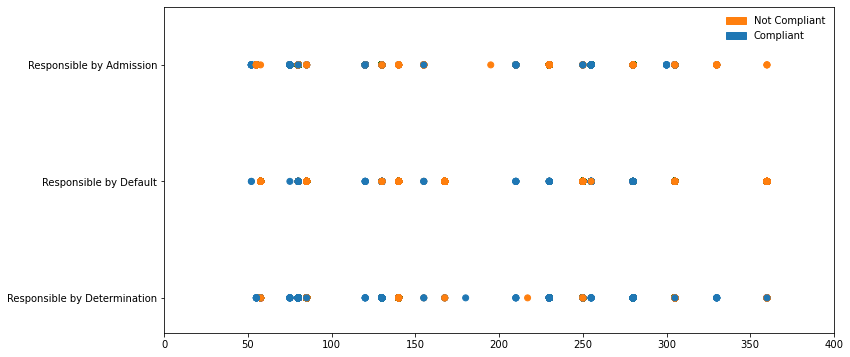

In [24]:
plot_compliance_scatter_features_chart(df, 'owed_amount', 'disposition_category', yticks=df['disposition'].unique(), xlim=(0,400), ylim=(-0.3,2.5))

## violations

In [25]:
total_people_violations = df['violation_code'].value_counts().dropna()
total_compliant_people_violations = df[df['compliance'] == 1]['violation_code'].value_counts().dropna()
total_non_compliant_people_violations = df[df['compliance'] == 0]['violation_code'].value_counts().dropna()
total_people_violations.head(20)

9-1-36(a)               41211
9-1-81(a)               13835
22-2-88                  9846
9-1-104                  8625
22-2-45                  2888
9-1-105                  2361
9-1-110(a)               2226
22-2-88(b)               2097
22-2-22                  1852
9-1-43(a) - (Dwellin     1681
9-1-103(C)               1407
22-2-43                  1370
22-2-17                   948
19450901                  838
22-2-61                   485
61-81.0100/32.0066        385
22-2-83(a)(b)(c)          356
9-1-43(a) - (Structu      277
22-2-83                   261
9-1-82(d) - (Dwellin      217
Name: violation_code, dtype: int64

In [26]:
total_compliant_people_violations

9-1-36(a)             3022
9-1-104                659
22-2-88                627
9-1-81(a)              422
22-2-45                351
                      ... 
9-1-103 (a) or (b)       1
22-2-49(d)               1
22-2-55                  1
9-1-210                  1
22-2-83(b)               1
Name: violation_code, Length: 76, dtype: int64

In [27]:
total_non_compliant_people_violations

9-1-36(a)              38189
9-1-81(a)              13413
22-2-88                 9219
9-1-104                 7966
22-2-45                 2537
                       ...  
22-2-21(a)                 1
61-90.0100                 1
9-1-443(b)                 1
61-111.0100/32.0066        1
22-2-94                    1
Name: violation_code, Length: 163, dtype: int64

In [28]:
df.query('violation_code in @total_people_violations.head().index')[['violation_code', 'violation_description']].drop_duplicates()

,violation_code,violation_description
ticket_id,,
18657,9-1-36(a),Failure of owner to obtain certificate of comp...
18954,22-2-88,"Failure of owner to keep property, its sidewal..."
19432,22-2-45,Violation of time limit for approved container...
20127,9-1-104,Excessive weeds or plant growth one- or two-fa...
24848,9-1-81(a),Failure to obtain certificate of registration ...
239220,22-2-88,"Failure of owner to keep property, its sidewal..."


# Model Selection

Analysing the charts and information displayed above, we can notice that no evident linear pattern that efficiently represents the data was found. So a model with higher complexity, like logistic regression or random forest, will be trained to do the predictions.

## Dummy Classifier

I got the values from a dummy classifier, just to explicitly present the minimum expected values of accuracy and ROC AUC score

In [29]:
def blight_dummy_model():
    from sklearn.dummy import DummyClassifier

    # Prepare the datasets
    columns = ['owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, scoring='roc_auc', cv=10)))

In [30]:
blight_dummy_model()

Cross-validation accuracy:  0.9300474645635453
Cross-validation AUC:  0.5


## Logistic Regression

In [31]:
def blight_logistic_model():
    from sklearn.linear_model import LogisticRegression

    # Prepare the datasets
    columns = ['owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(LogisticRegression(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='roc_auc', cv=10)))

In [32]:
blight_logistic_model()

Cross-validation accuracy:  0.9300474645635453
Cross-validation AUC:  0.653046020796134


## SVM

In [33]:
def blight_svm_model():
    from sklearn.svm import SVC

    # Prepare the datasets
    columns = ['owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(SVC(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(SVC(), X, y, scoring='roc_auc', cv=10)))

In [34]:
blight_svm_model()

Cross-validation accuracy:  0.9300474645635453
Cross-validation AUC:  0.5044899023318486


## Random Forest

In [35]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc', cv=10)))

In [36]:
blight_random_forest_model()

Cross-validation accuracy:  0.9363164672168572
Cross-validation AUC:  0.7549081301721899


The Random Forest Default Model presented the best scores, so I will use and tune it

### Added the LabelEncoder to 'disposition' column

In [37]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['disposition', 'owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    
    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc', cv=10)))

In [38]:
blight_random_forest_model()

Cross-validation accuracy:  0.9451103765137134
Cross-validation AUC:  0.7937548360617461


### Added the LabelEncoder to 'violation_code' column

In [39]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['violation_code', 'owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)

    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
    X['violation_code'] = transform(le_violation, X['violation_code'])

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc', cv=10)))

In [40]:
blight_random_forest_model()

Cross-validation accuracy:  0.935242052146951
Cross-validation AUC:  0.7655328301617047


### Added the LabelEncoder to 'disposition' and 'violation_code' columns

In [41]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['disposition', 'violation_code', 'owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)   
    
    # Prepare the disposition LabelEncodera
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])
    
    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
    X['violation_code'] = transform(le_violation, X['violation_code'])

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc', cv=10)))

In [42]:
blight_random_forest_model()

Cross-validation accuracy:  0.9440672636120471
Cross-validation AUC:  0.7984906624888672


### Hyperparameter Tuning

#### Randomized Search CV

In [165]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

# Prepare the datasets
columns = ['disposition', 'violation_code', 'discount_amount', 'owed_amount']
X, y = prepare_train_dataset('csv/train.csv', columns)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Prepare the disposition LabelEncoder
le_disposition = LabelEncoder().fit(list(X_train['disposition']) + ['Unknown'])
X_train['disposition'] = transform(le_disposition, X_train['disposition'])

# Prepare the violation LabelEncoder
le_violation = LabelEncoder().fit(list(X_train['violation_code']) + ['Unknown'])
X_train['violation_code'] = transform(le_violation, X_train['violation_code'])
    
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


<ipython-input-150-6b8e6707189f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-165-dddd88928b9e>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['disposition'] = transform(le_disposition, X_train['disposition'])
<ipython-input-165-dddd88928b9e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 91.7min finished


{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [166]:
rf_random.best_score_

0.8022249934589883

#### Grid Search CV

In [167]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [3, 5, 10],
    'n_estimators': [1000, 1500, 2000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc', 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 10.3min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [168]:
grid_search.best_score_

0.8023437209004308

In [169]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [216]:
def blight_random_forest_model(bootstrap=True, max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=100):
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['disposition', 'violation_code', 'owed_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)   
    
    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])
    
    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
    X['violation_code'] = transform(le_violation, X['violation_code'])
    
    rf = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, max_features=max_features, 
                        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(rf, X, y, cv=10)))
    print('Cross-validation AUC: ', np.mean(cross_val_score(rf, X, y, scoring='roc_auc', cv=10)))

In [171]:
blight_random_forest_model(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=1500)

<ipython-input-150-6b8e6707189f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')


Cross-validation accuracy:  0.9466103251883153
Cross-validation AUC:  0.7995390066751902


The auc score got better, but the time of execution increased a lot, so I reduced the n_estimators to 10.

In [217]:
blight_random_forest_model(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=10)

Cross-validation accuracy:  0.9441089563112612
Cross-validation AUC:  0.8028877701280177


## Save Model

In [44]:
import joblib as jb
from sklearn.ensemble import RandomForestClassifier

# Prepare the datasets
columns = ['disposition', 'violation_code', 'owed_amount']
X, y = prepare_train_dataset('csv/train.csv', columns)   

# Prepare the disposition LabelEncoder
le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
X['disposition'] = transform(le_disposition, X['disposition'])

# Prepare the violation LabelEncoder
le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
X['violation_code'] = transform(le_violation, X['violation_code'])

rf = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, 
                            n_estimators=10)
rf.fit(X,y)

jb.dump(rf,"model/rf_blight_ticket.pk;.z")
jb.dump(le_disposition,"model/le_disposition_blight_ticket.pk;.z")
jb.dump(le_violation,"model/le_violation_blight_ticket.pk;.z")

['model/le_violation_blight_ticket.pk;.z']